In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, LayerNormalization, Multiply, Reshape, Concatenate, Layer)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal, Orthogonal, Zeros
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import random
import ast

In [2]:
df1=pd.read_csv('symtoms_df.csv')
df2=pd.read_csv('Symptom-severity.csv')

In [3]:
df1.head()

,Unnamed: 0,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches
1,1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN
2,2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN
3,3,Fungal infection,itching,skin_rash,dischromic _patches,NaN
4,4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN


In [4]:
df2.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [5]:
print(df2.to_markdown())

|     | Symptom                        |   weight |
|----:|:-------------------------------|---------:|
|   0 | itching                        |        1 |
|   1 | skin_rash                      |        3 |
|   2 | nodal_skin_eruptions           |        4 |
|   3 | continuous_sneezing            |        4 |
|   4 | shivering                      |        5 |
|   5 | chills                         |        3 |
|   6 | joint_pain                     |        3 |
|   7 | stomach_pain                   |        5 |
|   8 | acidity                        |        3 |
|   9 | ulcers_on_tongue               |        4 |
|  10 | muscle_wasting                 |        3 |
|  11 | vomiting                       |        5 |
|  12 | burning_micturition            |        6 |
|  13 | spotting_urination             |        6 |
|  14 | fatigue                        |        4 |
|  15 | weight_gain                    |        3 |
|  16 | anxiety                        |        4 |
|  17 | cold

In [6]:
df1['Symptom_4'].fillna('',inplace=True)

C:\Users\moin2\AppData\Local\Temp\ipykernel_2560\1593813174.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Symptom_4'].fillna('',inplace=True)


In [7]:
df1['Symptoms']=df1['Symptom_1']+','+df1['Symptom_2']+','+df1['Symptom_3']+','+df1['Symptom_4']

In [8]:
df1=df1[['Symptoms','Disease']]

In [9]:
df1['Symptoms']=df1['Symptoms'].str.replace('_',' ')

In [10]:
df1.tail()

,Symptoms,Disease
4915,"vomiting, headache, nausea, spinning movements",(vertigo) Paroymsal Positional Vertigo
4916,"skin rash, pus filled pimples, blackheads, sc...",Acne
4917,"burning micturition, bladder discomfort, foul...",Urinary tract infection
4918,"skin rash, joint pain, skin peeling, silver l...",Psoriasis
4919,"skin rash, high fever, blister, red sore arou...",Impetigo


In [11]:
df2.tail()

,Symptom,weight
128,inflammatory_nails,2
129,blister,4
130,red_sore_around_nose,2
131,yellow_crust_ooze,3
132,prognosis,5


In [12]:
# Convert df2 into a dictionary: symptom -> weight
severity_dict = dict(zip(df2['Symptom'], df2['weight']))

In [13]:
# just want to check unique weights
set(severity_dict.values())

{1, 2, 3, 4, 5, 6, 7}

In [14]:
# --------------------------------------
# 3. Preprocess Symptoms from df1
# --------------------------------------
def preprocess_symptoms(symptom_str):
    """
    Converts comma-separated symptoms into a list of standardized tokens.
    1) Lowercase
    2) Trim spaces
    3) Replace inner spaces with underscores
    """
    # Split on commas
    symptoms = symptom_str.lower().split(',')
    # Clean each symptom token
    symptoms = [s.strip().replace(' ', '_') for s in symptoms]
    return symptoms

In [15]:
# Create a new column in df1 with the list of symptoms

df1['Symptom_list'] = df1['Symptoms'].apply(preprocess_symptoms)

In [16]:
df1.head()

,Symptoms,Disease,Symptom_list
0,"itching, skin rash, nodal skin eruptions, disc...",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,"skin rash, nodal skin eruptions, dischromic ...",Fungal infection,"[skin_rash, nodal_skin_eruptions, dischromic__..."
2,"itching, nodal skin eruptions, dischromic pat...",Fungal infection,"[itching, nodal_skin_eruptions, dischromic__pa..."
3,"itching, skin rash, dischromic patches,",Fungal infection,"[itching, skin_rash, dischromic__patches, ]"
4,"itching, skin rash, nodal skin eruptions,",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ]"


In [17]:
# ----------------------------------------------------
# 4. Tokenize the Symptoms (build a vocabulary)
# ----------------------------------------------------
# Flatten all symptom tokens to build a complete vocabulary

all_symptoms = [sym for row in df1['Symptom_list'] for sym in row]

tokenizer = Tokenizer(lower=True, filters='')  # no filters, since we've already cleaned
tokenizer.fit_on_texts(all_symptoms)


In [18]:
# ----------------------------------------------------
# 5. Convert Each List of Symptoms into Integer Sequences
# ----------------------------------------------------
# For each row, convert the list of symptom tokens into their integer IDs

df1['Symptom_seq'] = df1['Symptom_list'].apply(lambda x: tokenizer.texts_to_sequences(x))

# Flatten the list-of-lists for each row

df1['Symptom_seq'] = df1['Symptom_seq'].apply(lambda seq: [item for sublist in seq for item in sublist])


In [19]:
df1.head()

,Symptoms,Disease,Symptom_list,Symptom_seq
0,"itching, skin rash, nodal skin eruptions, disc...",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, dis...","[8, 5, 56, 57]"
1,"skin rash, nodal skin eruptions, dischromic ...",Fungal infection,"[skin_rash, nodal_skin_eruptions, dischromic__...","[5, 56, 57]"
2,"itching, nodal skin eruptions, dischromic pat...",Fungal infection,"[itching, nodal_skin_eruptions, dischromic__pa...","[8, 56, 57]"
3,"itching, skin rash, dischromic patches,",Fungal infection,"[itching, skin_rash, dischromic__patches, ]","[8, 5, 57]"
4,"itching, skin rash, nodal skin eruptions,",Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ]","[8, 5, 56]"


In [20]:
def shuffle_symptoms(row):
    """
    Takes a row with 'Symptoms', 'Symptom_list', and 'Symptom_seq'.
    Shuffles the symptom tokens (and corresponding token IDs) so that
    the mapping between symptom and token ID remains consistent.
    Returns new columns with the shuffled data.
    """
    # Pair each token with its corresponding token ID
    pairs = list(zip(row["Symptom_list"], row["Symptom_seq"]))

    # Shuffle the (token, token_id) pairs in place
    random.shuffle(pairs)

    # Unzip the shuffled pairs back into separate lists
    shuffled_symptoms, shuffled_seq = zip(*pairs)

    # Reconstruct the "Symptoms" string by joining shuffled tokens with commas
    shuffled_symptoms_str = ", ".join(shuffled_symptoms)

    # Return a Series containing the shuffled versions
    return pd.Series({
        "Shuffled_Symptoms": shuffled_symptoms_str,
        "Shuffled_Symptom_list": list(shuffled_symptoms),
        "Shuffled_Symptom_seq": list(shuffled_seq)
    })

In [21]:
# Apply the shuffle function row-by-row
df1[["Shuffled_Symptoms", "Shuffled_Symptom_list", "Shuffled_Symptom_seq"]] = df1.apply(shuffle_symptoms, axis=1)

# Display the Disease column as well as original and shuffled columns
df1[[
    "Symptoms", "Disease", "Symptom_list", "Symptom_seq",
    "Shuffled_Symptoms", "Shuffled_Symptom_list", "Shuffled_Symptom_seq"
]].head()
df1=df1.drop(columns={'Symptoms','Symptom_list','Symptom_seq'})

In [22]:
df1.head()

,Disease,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq
0,Fungal infection,"dischromic__patches, nodal_skin_eruptions, ski...","[dischromic__patches, nodal_skin_eruptions, sk...","[57, 56, 5, 8]"
1,Fungal infection,"skin_rash, nodal_skin_eruptions, dischromic__p...","[skin_rash, nodal_skin_eruptions, dischromic__...","[5, 56, 57]"
2,Fungal infection,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]"
3,Fungal infection,"itching, skin_rash, dischromic__patches","[itching, skin_rash, dischromic__patches]","[8, 5, 57]"
4,Fungal infection,"itching, nodal_skin_eruptions, skin_rash","[itching, nodal_skin_eruptions, skin_rash]","[8, 56, 5]"


In [23]:
# ----------------------------------------------------
# 6. Pad the Sequences
# ----------------------------------------------------
max_length = max(df1['Shuffled_Symptom_seq'].apply(len))  # maximum length of any symptom sequence
X = pad_sequences(df1['Shuffled_Symptom_seq'], maxlen=max_length, padding='post', dtype='int32')



In [24]:
# ----------------------------------------------------
# 7. Encode Disease Labels
# ----------------------------------------------------
le = LabelEncoder()

y = le.fit_transform(df1['Disease'])

# Convert to one-hot vectors for a multi-class classification problem

y = tf.keras.utils.to_categorical(y)


In [25]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [26]:
# ----------------------------------------------------
# 8. Build a Weight Vector for the Vocabulary
# ----------------------------------------------------
# We'll create a numpy array, where each index corresponds to a token ID.
# If a token is found in severity_dict, use that weight; otherwise, default to 1.
vocab_size = len(tokenizer.word_index)
embedding_scaling = np.ones(vocab_size + 1, dtype=np.float32)  # +1 because index 0 is reserved (padding)

for token, index in tokenizer.word_index.items():
    if token in severity_dict:
        embedding_scaling[index] = severity_dict[token]
    else:
        embedding_scaling[index] = 1.0  # default severity weight

# Convert it to a constant tensor so it won't be trainable
embedding_scaling = tf.constant(embedding_scaling)


In [27]:
np.unique(embedding_scaling)

array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [28]:
df1=df1[['Shuffled_Symptoms','Shuffled_Symptom_list','Shuffled_Symptom_seq','Disease']]
df1.head()

,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq,Disease
0,"dischromic__patches, nodal_skin_eruptions, ski...","[dischromic__patches, nodal_skin_eruptions, sk...","[57, 56, 5, 8]",Fungal infection
1,"skin_rash, nodal_skin_eruptions, dischromic__p...","[skin_rash, nodal_skin_eruptions, dischromic__...","[5, 56, 57]",Fungal infection
2,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]",Fungal infection
3,"itching, skin_rash, dischromic__patches","[itching, skin_rash, dischromic__patches]","[8, 5, 57]",Fungal infection
4,"itching, nodal_skin_eruptions, skin_rash","[itching, nodal_skin_eruptions, skin_rash]","[8, 56, 5]",Fungal infection


In [29]:
df2.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [30]:
'''' Here you Need to Think of a New Approach How to deal with further  Shuffled_Symptom_seq and weights'''
'''one way is to put most weighted symptoms in last and least weighted symptoms first so that LSTM
   remembers High weighted one in the sequence in this weights also used and LSTM also works fine try this 
   Approach and see result
   in UI in First two selectbox user enters common symptoms and in last two most severe symptoms'''

'one way is to put most weighted symptoms in last and least weighted symptoms first so that LSTM\n   remembers High weighted one in the sequence in this weights also used and LSTM also works fine try this \n   Approach and see result\n   in UI in First two selectbox user enters common symptoms and in last two most severe symptoms'

In [31]:
''' Can we here think of New Model also despite LSTMs and RNNs --- Yes we use Some of the Attention Mechanism alse
    Rather than juss stick to RNN and LSTMs'''

' Can we here think of New Model also despite LSTMs and RNNs --- Yes we use Some of the Attention Mechanism alse\n    Rather than juss stick to RNN and LSTMs'

In [32]:
# Create a dictionary: {symptom: weight}
weight_map = dict(zip(df2["Symptom"], df2["weight"]))


In [33]:
weight_map

{'itching': 1,
 'skin_rash': 3,
 'nodal_skin_eruptions': 4,
 'continuous_sneezing': 4,
 'shivering': 5,
 'chills': 3,
 'joint_pain': 3,
 'stomach_pain': 5,
 'acidity': 3,
 'ulcers_on_tongue': 4,
 'muscle_wasting': 3,
 'vomiting': 5,
 'burning_micturition': 6,
 'spotting_urination': 6,
 'fatigue': 4,
 'weight_gain': 3,
 'anxiety': 4,
 'cold_hands_and_feets': 5,
 'mood_swings': 3,
 'weight_loss': 3,
 'restlessness': 5,
 'lethargy': 2,
 'patches_in_throat': 6,
 'irregular_sugar_level': 5,
 'cough': 4,
 'high_fever': 7,
 'sunken_eyes': 3,
 'breathlessness': 4,
 'sweating': 3,
 'dehydration': 4,
 'indigestion': 5,
 'headache': 3,
 'yellowish_skin': 3,
 'dark_urine': 4,
 'nausea': 5,
 'loss_of_appetite': 4,
 'pain_behind_the_eyes': 4,
 'back_pain': 3,
 'constipation': 4,
 'abdominal_pain': 4,
 'diarrhoea': 6,
 'mild_fever': 5,
 'yellow_urine': 4,
 'yellowing_of_eyes': 4,
 'acute_liver_failure': 6,
 'fluid_overload': 4,
 'swelling_of_stomach': 7,
 'swelled_lymph_nodes': 6,
 'malaise': 6,
 'bl

In [34]:
# For any symptom not in weight_map, use a default weight of 0
df1["Symptom_Weights"] = df1["Shuffled_Symptom_list"].apply(
    lambda sym_list: [weight_map.get(sym,1) for sym in sym_list]
)

In [35]:
df1.head()

,Shuffled_Symptoms,Shuffled_Symptom_list,Shuffled_Symptom_seq,Disease,Symptom_Weights
0,"dischromic__patches, nodal_skin_eruptions, ski...","[dischromic__patches, nodal_skin_eruptions, sk...","[57, 56, 5, 8]",Fungal infection,"[1, 4, 3, 1]"
1,"skin_rash, nodal_skin_eruptions, dischromic__p...","[skin_rash, nodal_skin_eruptions, dischromic__...","[5, 56, 57]",Fungal infection,"[3, 4, 1]"
2,"dischromic__patches, itching, nodal_skin_erupt...","[dischromic__patches, itching, nodal_skin_erup...","[57, 8, 56]",Fungal infection,"[1, 1, 4]"
3,"itching, skin_rash, dischromic__patches","[itching, skin_rash, dischromic__patches]","[8, 5, 57]",Fungal infection,"[1, 3, 1]"
4,"itching, nodal_skin_eruptions, skin_rash","[itching, nodal_skin_eruptions, skin_rash]","[8, 56, 5]",Fungal infection,"[1, 4, 3]"


In [36]:
df2.weight.unique()

array([1, 3, 4, 5, 6, 2, 7])

In [37]:
df1=df1[['Shuffled_Symptoms','Shuffled_Symptom_list','Symptom_Weights','Disease']]

In [38]:
df1.tail()

,Shuffled_Symptoms,Shuffled_Symptom_list,Symptom_Weights,Disease
4915,"vomiting, headache, spinning_movements, nausea","[vomiting, headache, spinning_movements, nausea]","[5, 3, 6, 5]",(vertigo) Paroymsal Positional Vertigo
4916,"skin_rash, pus_filled_pimples, blackheads, scu...","[skin_rash, pus_filled_pimples, blackheads, sc...","[3, 2, 2, 2]",Acne
4917,"continuous_feel_of_urine, burning_micturition,...","[continuous_feel_of_urine, burning_micturition...","[6, 6, 1, 4]",Urinary tract infection
4918,"skin_peeling, joint_pain, skin_rash, silver_li...","[skin_peeling, joint_pain, skin_rash, silver_l...","[3, 3, 3, 2]",Psoriasis
4919,"skin_rash, high_fever, red_sore_around_nose, b...","[skin_rash, high_fever, red_sore_around_nose, ...","[3, 7, 2, 4]",Impetigo


In [39]:
df1.shape

(4920, 4)

In [40]:
df1[df1['Disease'].str.contains('Heart')].shape

(120, 4)

In [41]:
import ast

def safe_literal_eval(x):
    # If it's already a list, return it as-is.
    if isinstance(x, list):
        return x
    # Otherwise, try to evaluate the string representation
    try:
        return ast.literal_eval(x)
    except Exception as e:
        print(f"Error parsing {x}: {e}")
        return x

# Apply the safe evaluation function to the Symptom_Weights column.
df1['Symptom_Weights'] = df1['Symptom_Weights'].apply(safe_literal_eval)


In [42]:
df1['Symptom_Weights']

0       [1, 4, 3, 1]
1          [3, 4, 1]
2          [1, 1, 4]
3          [1, 3, 1]
4          [1, 4, 3]
            ...     
4915    [5, 3, 6, 5]
4916    [3, 2, 2, 2]
4917    [6, 6, 1, 4]
4918    [3, 3, 3, 2]
4919    [3, 7, 2, 4]
Name: Symptom_Weights, Length: 4920, dtype: object

In [43]:
# Process the symptoms: we assume they are a comma-separated string.
# If needed, you can further process (strip spaces, etc.)
df1['Symptom_Tokens'] = df1['Shuffled_Symptoms'].apply(lambda x: [sym.strip() for sym in x.split(',')])


In [44]:
# Determine maximum sequence length (number of symptoms per record)
max_len = df1['Symptom_Tokens'].apply(len).max()
max_len

np.int64(4)

In [45]:
# Prepare tokenizer on the symptom tokens
all_symptoms = df1['Symptom_Tokens'].tolist()
# Flatten the list of tokens
flat_symptoms = [sym for sublist in all_symptoms for sym in sublist]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(flat_symptoms)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

143


In [46]:
# Convert each record's symptom tokens to sequences of integers
df1['Symptom_Seq'] = df1['Symptom_Tokens'].apply(lambda tokens: tokenizer.texts_to_sequences(tokens))
# texts_to_sequences returns list of lists, so flatten each record
df1['Symptom_Seq'] = df1['Symptom_Seq'].apply(lambda seq_list: [item for sub in seq_list for item in sub])
# Pad sequences to uniform length (pad with zeros)
symptom_seqs = pad_sequences(df1['Symptom_Seq'], maxlen=max_len, padding='post')


In [47]:
symptom_seqs

array([[88,  4, 11, 13],
       [ 4, 88, 86, 42],
       [13, 87,  4, 88],
       ...,
       [ 5, 18, 75, 76],
       [11, 77, 78, 79],
       [82, 83, 84, 85]], dtype=int32)

In [48]:
# Similarly, pad the weights. We assume weights are given in order.
# If a record has fewer weights than max_len, pad with zeros.
weights = np.array([np.pad(w, (0, max_len - len(w)), 'constant') for w in df1['Symptom_Weights']])
weights

array([[1, 4, 3, 1],
       [3, 4, 1, 0],
       [1, 1, 4, 0],
       ...,
       [6, 6, 1, 4],
       [3, 3, 3, 2],
       [3, 7, 2, 4]])

In [49]:
# Encode the disease labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df1['Disease'])
num_classes = len(label_encoder.classes_)
labels_cat = to_categorical(labels, num_classes=num_classes)


In [50]:
# Train-test split
X_symptoms_train, X_symptoms_test, X_weights_train, X_weights_test, y_train, y_test = train_test_split(
    symptom_seqs, weights, labels_cat, test_size=0.2, random_state=42
)

In [51]:
# -------------------------
# 2. Build the LSTM Model
# -------------------------
embedding_dim = 512  # Adjust embedding size as needed


In [52]:
# Input layers
symptoms_input = Input(shape=(max_len,), name="symptoms_input")
weights_input = Input(shape=(max_len,), name="weights_input")


In [53]:
# Embedding layer for symptoms
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            name="symptom_embedding")
embedded_symptoms = embedding_layer(symptoms_input)


c:\Users\moin2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
# Reshape weights to multiply with embedding output
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)
# Multiply embeddings by weights (element-wise multiplication)
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])

In [55]:
weighted_embedding

<KerasTensor shape=(None, np.int64(4), 512), dtype=float32, sparse=False, name=keras_tensor_2>

In [56]:
# Reshape weights to match the dimensions of the embeddings (for element-wise multiplication)
weights_reshaped = Reshape((max_len, 1), name="reshape_weights")(weights_input)

# Multiply the embeddings by the corresponding weights
weighted_embedding = Multiply(name="weighted_embedding")([embedded_symptoms, weights_reshaped])

In [57]:
# LSTM layer with recurrent_dropout to force the fallback (non-cuDNN) implementation
lstm_out = LSTM(512, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0.2,  # This parameter forces the non-cuDNN kernel
                name="lstm_layer")(weighted_embedding)


In [58]:
# Add a dense layer for further processing
dense1 = Dense(128, activation='relu', name="dense_layer")(lstm_out)
# Output layer with softmax activation for multi-class classification
output = Dense(num_classes, activation='softmax', name="output_layer")(dense1)

In [59]:
# Build and compile the model
model = Model(inputs=[symptoms_input, weights_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symptoms_input      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weights_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symptom_embedding   │ (None, 4, 512)    │     73,216 │ symptoms_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_weights     │ (None, 4, 1)      │          0 │ weights_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_embedding  │ (None, 4, 512)    │          0 │ symptom_embeddin… │
│ (Multiply)          │                   │            │ reshape_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 512)       │  2,099,200 │ weighted_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 128)       │     65,664 │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 41)        │      5,289 │ dense_layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,243,369 (8.56 MB)

 Trainable params: 2,243,369 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# -------------------------
# 3. Train the Model
# -------------------------
batch_size = 32
epochs = 1000 # Increase epochs if necessary

history = model.fit(
    [X_symptoms_train, X_weights_train], y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5593 - loss: 2.0758 - val_accuracy: 0.8959 - val_loss: 0.3127
Epoch 2/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9060 - loss: 0.2672 - val_accuracy: 0.9492 - val_loss: 0.1989
Epoch 3/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9307 - loss: 0.1717 - val_accuracy: 0.9264 - val_loss: 0.1914
Epoch 4/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9308 - loss: 0.1675 - val_accuracy: 0.9492 - val_loss: 0.1902
Epoch 5/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9433 - loss: 0.1357 - val_accuracy: 0.9213 - val_loss: 0.2281
Epoch 6/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9470 - loss: 0.1326 - val_accuracy: 0.9239 - val_loss: 0.2386
Epoch 7/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9390 - loss: 0.1366 - val_accuracy: 0.9264 - val_loss: 0.2159
Epoch 8/1000
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9481 - loss: 0

Training Loss per Epoch: [1.1047232151031494, 0.22070646286010742, 0.18642540276050568, 0.15308868885040283, 0.1424235999584198, 0.13100984692573547, 0.1330299824476242, 0.11933767050504684, 0.11498575657606125, 0.12257509678602219, 0.10440509021282196, 0.09923392534255981, 0.11198285222053528, 0.09594957530498505, 0.098381906747818, 0.12957443296909332, 0.1089491993188858, 0.0908946767449379, 0.0938400849699974, 0.08676838129758835, 0.08716311305761337, 0.07995855063199997, 0.08514025807380676, 0.07945442944765091, 0.09119709581136703, 0.07863491773605347, 0.07967852056026459, 0.08267700672149658, 0.08282294124364853, 0.07628393918275833, 0.07518012076616287, 0.10581099987030029, 0.08686599135398865, 0.0779581218957901, 0.07639187574386597, 0.07807039469480515, 0.08099361509084702, 0.07758382707834244, 0.07105791568756104, 0.07084304839372635, 0.08068551868200302, 0.08487243205308914, 0.07096999883651733, 0.07348208129405975, 0.07295408844947815, 0.06756976246833801, 0.068418771028518

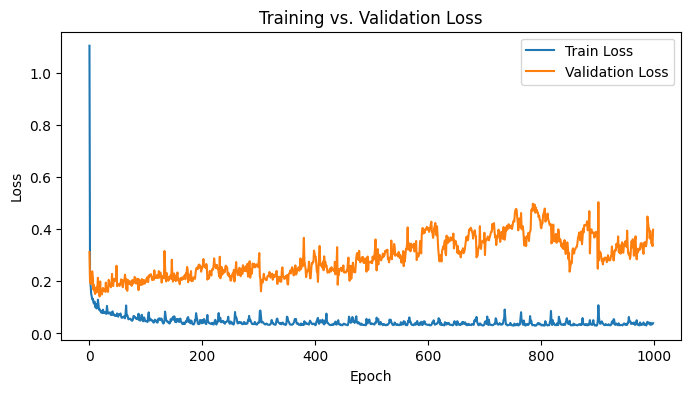

In [61]:
# ----------------------------------------------------------------
# Print and Plot Train vs. Validation Loss
# ----------------------------------------------------------------
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training Loss per Epoch:", train_loss)
print("Validation Loss per Epoch:", val_loss)

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

Training Accuracy per Epoch: [0.7382834553718567, 0.918690025806427, 0.9271597862243652, 0.9373235702514648, 0.9415584206581116, 0.948334276676178, 0.9418407678604126, 0.948334276676178, 0.9508752226829529, 0.9508752226829529, 0.9553924202919006, 0.9559571146965027, 0.9463579654693604, 0.95652174949646, 0.9587803483009338, 0.9545454382896423, 0.9553924202919006, 0.9601919651031494, 0.9593449831008911, 0.9570863842964172, 0.9556747674942017, 0.9647092223167419, 0.9584980010986328, 0.961885929107666, 0.9596273303031921, 0.9604743123054504, 0.9627329111099243, 0.9604743123054504, 0.9613212943077087, 0.9644268751144409, 0.9680970907211304, 0.9556747674942017, 0.9593449831008911, 0.962168276309967, 0.9624505639076233, 0.9635798931121826, 0.9635798931121826, 0.9669678211212158, 0.9686617851257324, 0.9666854739189148, 0.9624505639076233, 0.9627329111099243, 0.9683794379234314, 0.9666854739189148, 0.9632975459098816, 0.9686617851257324, 0.9680970907211304, 0.970073401927948, 0.9675324559211731

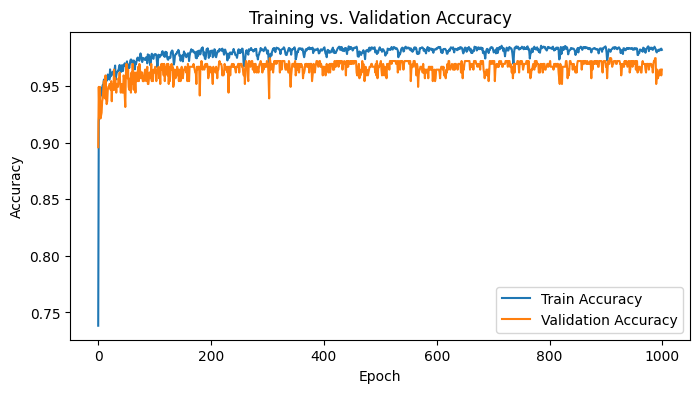

In [62]:
# ----------------------------------------------------------------
# Print and Plot Train vs. Validation Accuracy
# ----------------------------------------------------------------
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training Accuracy per Epoch:", train_acc)
print("Validation Accuracy per Epoch:", val_acc)

plt.figure(figsize=(8, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

In [63]:
# -------------------------
# 4. Evaluate the Model
# -------------------------
loss, accuracy = model.evaluate([X_symptoms_test, X_weights_test], y_test, verbose=0)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")


Test Loss: 0.3663 | Test Accuracy: 0.9593


In [1]:
# -------------------------
# 5. Making Predictions
# -------------------------

# For making predictions on new data, make sure to preprocess the symptom tokens and weights similarly.

# Example:

new_symptoms = "cold , cough , fever"
new_weights = [5, 6, 7]
new_tokens = [sym.strip() for sym in new_symptoms.split(',')]
new_seq = tokenizer.texts_to_sequences(new_tokens)
new_seq = [item for sub in new_seq for item in sub]
new_seq = pad_sequences([new_seq], maxlen=max_len, padding='post')
new_weights = np.array([np.pad(new_weights, (0, max_len - len(new_weights)), 'constant')])
prediction = model.predict([new_seq, new_weights])
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
print("Predicted Disease:", predicted_label[0])
predicted_disease = predicted_label[0]


NameError: name 'tokenizer' is not defined

In [69]:
predicted_disease

'Hypothyroidism'

In [71]:
symptoms = pd.read_csv("symtoms_df.csv")
precautions = pd.read_csv("precautions_df.csv")
workout = pd.read_csv("workout_df.csv")
description = pd.read_csv("description.csv")
medications = pd.read_csv('medications.csv')
diets = pd.read_csv("diets.csv")

In [70]:
def mapping(sample_dis):
    desc = description[description['Disease'] == sample_dis]['Description']
    desc = " ".join([w for w in desc])

    pre = precautions[precautions['Disease'] == sample_dis][['Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']]
    pre = [col for col in pre.values]

    med = medications[medications['Disease'] == sample_dis]['Medication']
    med = [med for med in med.values]

    die = diets[diets['Disease'] == sample_dis]['Diet']
    die = [die for die in die.values]

    wrkout = workout[workout['disease'] == sample_dis] ['workout']


    return desc,pre,med,die,wrkout

In [72]:
desc, pre, med, die, wrkout = mapping(predicted_disease)

print("predicted disease:")
print(predicted_disease)
print("description:")
print(desc)

print("precautions:")
for i in pre:
    print(i)   

print("medications:")
for i in med:
    print( i)
    

print("workout:")
for i in wrkout:
    print(i)
    

print("diets:")
for i in die:
    print(i)

predicted disease:
Hypothyroidism
description:
Hypothyroidism is a condition where the thyroid gland doesn't produce enough thyroid hormone.
precautions:
['reduce stress' 'exercise' 'eat healthy' 'get proper sleep']
medications:
['Antithyroid medications', 'Radioactive iodine', 'Thyroid surgery', 'Beta-blockers', 'Corticosteroids']
workout:
Include iodine-rich foods
Consume selenium-rich foods
Stay hydrated
Include nutrient-rich foods
Limit processed foods
Consume foods rich in vitamins B and D
Consult a healthcare professional
Follow medical recommendations
Maintain a stable weight
Engage in regular exercise
diets:
['Hypothyroidism Diet', 'Iodine-rich foods', 'Selenium-rich foods', 'Fruits and vegetables', 'Whole grains']


In [66]:
# Save the trained model
model.save('best_model.h5')
'''
# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and resources saved successfully!")'''

'\n# Save the tokenizer\nimport pickle\nwith open(\'tokenizer.pickle\', \'wb\') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n# Save the label encoder\nwith open(\'label_encoder.pickle\', \'wb\') as handle:\n    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\nprint("Model and resources saved successfully!")'

In [73]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# You might also want to save the max_len value as it's needed for preprocessing
with open('max_len.pickle', 'wb') as handle:
    pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and resources saved successfully!")

Model and resources saved successfully!
